# Chapter 7 - Hypergraphs

In this notebook, we introduce hypergraphs, a generalization of graphs where we allow for arbitrary sized edges (in practice, we consider edges of size 2 or more). We illustrate a few concepts using hypergraphs including modularity, community detection and transformation into 2-section graphs.

**This notebook requires version 2.1 or newer of the HyperNetX package** (https://github.com/pnnl/HyperNetX).



In [1]:
## Set this to the data directory
datadir='../Datasets/'


In [2]:
import pandas as pd
import numpy as np
import igraph as ig
import partition_igraph
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod ## new as of version 1.2
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from functools import reduce
import itertools
from scipy.special import comb
import warnings
import random
import networkx as nx
from sklearn.metrics import adjusted_mutual_info_score as AMI
from itertools import combinations
import seaborn as sns


# HyperNetX basics with a toy hypergraph

We illustrate a few concepts with a small toy hypergraph. 

First, we build the hnx hypergraph from a list of sets (the edges), and we draw the hypergraph as well as its dual (where the role of nodes and edges are swapped).


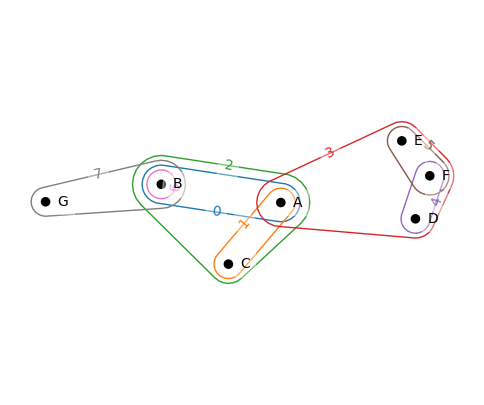

In [3]:
## build an hypergraph from a list of sets (the hyperedges)
## using 'enumerate', edges will have integer IDs
E = [{'A','B'},{'A','C'},{'A','B','C'},{'A','D','E','F'},{'D','F'},{'E','F'},{'B'},{'G','B'}]
kwargs = {'layout_kwargs': {'seed': 12}, 'with_node_counts': False}
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(6,5))
hnx.draw(HG, **kwargs)


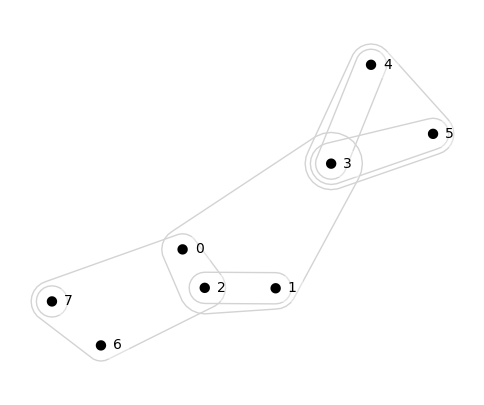

In [4]:
## dual hypergraph
HD = HG.dual()
kwargs = {'layout_kwargs': {'seed': 123}, 'with_node_counts': False, 'with_edge_labels':False}
sizes = np.array([HD.size(e) for e in HD.edges])
norm = plt.Normalize(sizes.min(),sizes.max())
edges_kwargs={'edgecolors':'lightgrey'}
plt.figure(figsize=(6,5))
hnx.draw(HD, **kwargs, edges_kwargs=edges_kwargs)

In [5]:
## show the nodes and edges
print('shape:', HG.shape)
print('nodes:', list(HG.nodes))
print('edges:', list(HG.edges))
print('node degrees:', [(v,HG.degree(v)) for v in HG.nodes()])
print('edge sizes:',[HG.size(e) for e in HG.edges()])

shape: (7, 8)
nodes: ['E', 'G', 'C', 'B', 'D', 'F', 'A']
edges: [0, 1, 2, 3, 4, 5, 6, 7]
node degrees: [('A', 4), ('B', 4), ('C', 2), ('D', 2), ('E', 2), ('F', 3), ('G', 1)]
edge sizes: [2, 2, 3, 4, 2, 2, 1, 2]


In [6]:
## incidence dictionary
HG.incidence_dict

{0: ['B', 'A'],
 1: ['C', 'A'],
 2: ['B', 'C', 'A'],
 3: ['D', 'E', 'F', 'A'],
 4: ['D', 'F'],
 5: ['F', 'E'],
 6: ['B'],
 7: ['G', 'B']}

In [7]:
## ordering of nodes (lexicographical)
[v for v in HG.nodes()]

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [8]:
## incidence matrix
df = pd.DataFrame(HG.incidence_matrix().toarray(), 
                  index=[v for v in HG.nodes()],
                  columns=['edge_'+str(i) for i in np.arange(0,8)])
df

,edge_0,edge_1,edge_2,edge_3,edge_4,edge_5,edge_6,edge_7
A,1,1,1,1,0,0,0,0
B,1,0,1,0,0,0,1,1
C,0,1,1,0,0,0,0,0
D,0,0,0,1,1,0,0,0
E,0,0,0,1,0,1,0,0
F,0,0,0,1,1,1,0,0
G,0,0,0,0,0,0,0,1


# hypergraph modularity qH

We compute qH on the toy graph for 4 different partitions, and using different variations for the edge contribution.

For edges of size $d$ where $c$ is the number of nodes from the part with the most representatives, we consider  variations as follows for edge contribution:

* **strict**: edges are considered only if all nodes are from the same part, with unit weight, i.e. $w$ = 1 iff $c == d$ (0 else).
* **cubic**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the cube of the number of nodes in the majority, i.e. $w = (c/d)^3$ iff $c>d/2$ (0 else).
* **quadratic**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the square of the number of nodes in the majority, i.e. $w = (c/d)^2$ iff $c>d/2$ (0 else).
* **linear**: edges are counted only if more that half the nodes are from the same part, with weights proportional to the number of nodes in the majority, i.e. $w = c/d$ iff $c>d/2$ (0 else).
* **majority**: edges are counted only if more that half the nodes are from the same part, with unit weights, i.e. $w$ = 1 iff $c>d/2$ (0 else).

Some of the above are supplied with the `hmod` module, the **qH2** and **qH3** functions are examples of user-supplied choice.

The order above goes from only counting "pure" edges as community edges, gradually giving more weight to edges with $c>d/2$, all the way to giving the the same weights.


In [9]:
## square modularity
def qH2(d,c):
    return (c/d)**2 if c > d/2 else 0
## cubic modularity
def qH3(d,c):
    return (c/d)**3 if c > d/2 else 0

## compute hypergraph modularity (qH) for the following partitions:
A1 = [{'A','B','C','G'},{'D','E','F'}]            ## good clustering, qH should be positive
A2 = [{'B','C'},{'A','D','E','F','G'}]            ## not so good
A3 = [{'A','B','C','D','E','F','G'}]              ## this should yield qH == 0
A4 = [{'A'},{'B'},{'C'},{'D'},{'E'},{'F'},{'G'}]  ## qH should be negative here

## we compute with different choices of functions for the edge contribution

print('strict edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(HG,A1,hmod.strict)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(HG,A2,hmod.strict)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(HG,A3,hmod.strict)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(HG,A4,hmod.strict)))
print('\nquadratic edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(HG,A1,qH3)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(HG,A2,qH3)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(HG,A3,qH3)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(HG,A4,qH3)))
print('\ncubic edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(HG,A1,qH2)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(HG,A2,qH2)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(HG,A3,qH2)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(HG,A4,qH2)))
print('\nlinear edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(HG,A1,hmod.linear)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(HG,A2,hmod.linear)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(HG,A3,hmod.linear)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(HG,A4,hmod.linear)))
print('\nmajority edge contribution:')
print('qH(A1):',"{:.4f}".format(hmod.modularity(HG,A1,hmod.majority)),
      'qH(A2):',"{:.4f}".format(hmod.modularity(HG,A2,hmod.majority)),
      'qH(A3):',"{:.4f}".format(hmod.modularity(HG,A3,hmod.majority)),
      'qH(A4):',"{:.4f}".format(hmod.modularity(HG,A4,hmod.majority)));


strict edge contribution:
qH(A1): 0.3659 qH(A2): -0.0401 qH(A3): 0.0000 qH(A4): -0.1088

quadratic edge contribution:
qH(A1): 0.3659 qH(A2): -0.0538 qH(A3): 0.0000 qH(A4): -0.1291

cubic edge contribution:
qH(A1): 0.3615 qH(A2): -0.0563 qH(A3): 0.0000 qH(A4): -0.1384

linear edge contribution:
qH(A1): 0.3535 qH(A2): -0.0586 qH(A3): 0.0000 qH(A4): -0.1520

majority edge contribution:
qH(A1): 0.3394 qH(A2): -0.0602 qH(A3): 0.0000 qH(A4): -0.1721


### 2-section graph

We build the 2-section graph for the above toy hypergraph, and run some graph custering on this graph.

We see different edge weights.

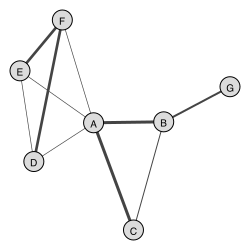

In [10]:
## 2-section graph
G = hmod.two_section(HG)
G.vs['label'] = G.vs['name']
ig.plot(G, bbox=(0,0,250,250), edge_width = 2*np.array(G.es['weight']), 
        vertex_color='gainsboro', vertex_label_size=10)


In [11]:
## 2-section clustering with Leiden
G.vs['community'] = G.community_leiden(objective_function='modularity', weights='weight').membership
print('clusters:',hmod.dict2part({v['name']:v['community'] for v in G.vs}))


clusters: [{'B', 'C', 'G', 'A'}, {'D', 'E', 'F'}]


In [12]:
## Kumar clustering
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cl = hmod.kumar(HG)
cl

[{'A', 'B', 'C', 'G'}, {'D', 'E', 'F'}]

# Game of Thrones scenes hypergraph

The original data can be found here: https://github.com/jeffreylancaster/game-of-thrones.
A pre-processed version is provided, where we consider an hypergraph from the game of thrones scenes with he following elements:

* **Nodes** are named characters in the series
* **Hyperedges** are groups of character appearing in the same scene(s)
* **Hyperedge weights** are total scene(s) duration in seconds involving each group of characters

We kept hyperedges with at least 2 characters and we discarded characters with degree below 5.

We saved the following:

* *Edges*: list of sets where the nodes are 0-based integers represented as strings: '0', '1', ... 'n-1'
* *Names*: dictionary; mapping of nodes to character names
* *Weights*: list; hyperedge weights (in same order as Edges)


In [13]:
## read the data
with open(datadir+"GoT/GoT.pkl","rb") as f:
    Edges, Names, Weights = pickle.load(f)


## Build the weighted hypergraph 

Use the above to build the weighted hypergraph (GoT).

In [14]:
## Nodes are represented as strings from '0' to 'n-1'
GoT = hnx.Hypergraph(dict(enumerate(Edges)))

## add edge weights
for e in GoT.edges:
    GoT.edges[e].weight = Weights[e]

## add full names of characters and compute node strength (a.k.a. weighted degree)
S = GoT.incidence_matrix() * np.array(GoT.edge_props['weight'])
Nodes = [v for v in GoT.nodes()]
for i in range(len(Nodes)):
    GoT.nodes[Nodes[i]].name = Names[Nodes[i]]
    GoT.nodes[Nodes[i]].strength = S[i]
    
print(GoT.number_of_nodes(),'nodes and',GoT.number_of_edges(),'edges')

173 nodes and 1432 edges


## EDA on the GoT hypergraph

Simple exploratory data analysis (EDA) on this hypergraph. 

max edge size: 24
median edge size: 3.0


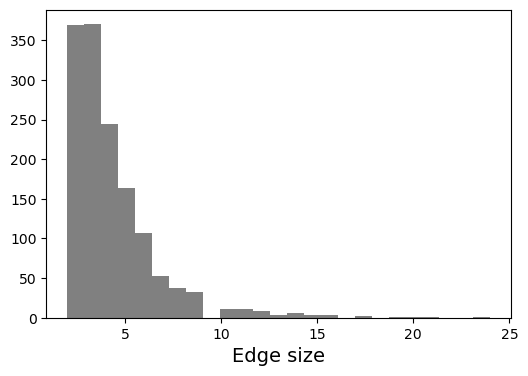

In [15]:
## edge sizes (number of characters per scene)
plt.figure(figsize=(6,4))
plt.hist([GoT.size(e) for e in GoT.edges], bins=25, color='grey')
plt.xlabel("Edge size", fontsize=14);
#plt.savefig('got_hist_1.eps');
## max edge size
print('max edge size:', np.max([GoT.size(e) for e in GoT.edges]))
print('median edge size:', np.median([GoT.size(e) for e in GoT.edges]))

max edge weight: 2995
median edge weight: 72.0


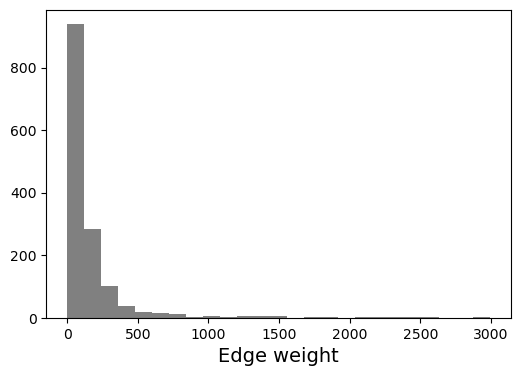

In [16]:
## edge weights (total scene durations for each group of characters appearing together)
plt.figure(figsize=(6,4))
plt.hist([GoT.edges[e].weight for e in GoT.edges], bins=25, color='grey')
plt.xlabel("Edge weight",fontsize=14);
#plt.savefig('got_hist_2.eps');
## max/median edge weight
print('max edge weight:', np.max([GoT.edges[e].weight for e in GoT.edges]))
print('median edge weight:', np.median([GoT.edges[e].weight for e in GoT.edges]))

max node degree: 306
median node degree: 17.0


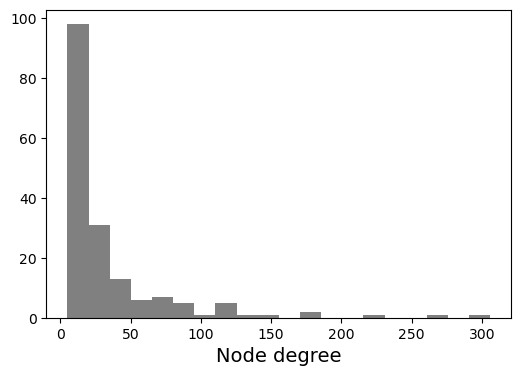

In [17]:
## node degrees
plt.figure(figsize=(6,4))
plt.hist(hnx.degree_dist(GoT),bins=20, color='grey')
plt.xlabel("Node degree",fontsize=14);
#plt.savefig('got_hist_3.eps');
## max degree
print('max node degree:', np.max(hnx.degree_dist(GoT)))
print('median node degree:', np.median(hnx.degree_dist(GoT)))

max node strength: 39899
median node strength: 2195.0


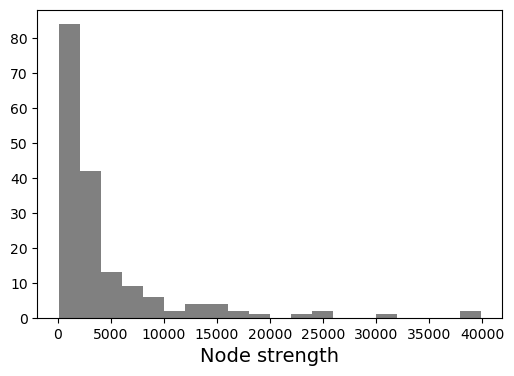

In [18]:
## node strength (total scene appearance)
plt.figure(figsize=(6,4))
plt.hist([GoT.nodes[n].strength for n in GoT.nodes], bins=20, color='grey')
plt.xlabel("Node strength",fontsize=14);
#plt.savefig('got_hist_4.eps');
## max strength
print('max node strength:', np.max([GoT.nodes[n].strength for n in GoT.nodes]))
print('median node strength:', np.median([GoT.nodes[n].strength for n in GoT.nodes]))

In [19]:
## build a dataframe with node characteristics
df = pd.DataFrame()
df['name'] = [GoT.nodes[v].name for v in GoT.nodes()]
df['degree'] = [GoT.degree(v) for v in GoT.nodes()]
df['strength'] = [GoT.nodes[v].strength for v in GoT.nodes()]


### add s-centrality and betweenness

In [20]:
%%time
bet = hnx.s_betweenness_centrality(GoT, edges=False)
har = hnx.s_harmonic_centrality(GoT, edges=False, normalized=True)
df['s_betweenness'] = [bet[v] for v in GoT.nodes()]
df['s_harmonic'] = [har[v] for v in GoT.nodes()]

CPU times: user 552 ms, sys: 6.84 ms, total: 559 ms
Wall time: 226 ms


In [21]:
df.sort_values(by='s_harmonic',ascending=False).head()

,name,degree,strength,s_betweenness,s_harmonic
85,Jon Snow,306,39221,0.083826,0.009010
94,Tyrion Lannister,263,39899,0.072250,0.009010
86,Jaime Lannister,153,22741,0.069752,0.008806
151,Sansa Stark,183,25009,0.045570,0.008806
162,Arya Stark,103,17775,0.104253,0.008500


## Build 2-section graph and compute a few centrality measures

We saw several centrality measures for graphs in chapter 3. Below, we build the 2-section graph for GoT and compute a few of those.


In [22]:
## build 2-section
G = hmod.two_section(GoT)

In [23]:
G.vs['pr'] = G.pagerank(directed=False,weights='weight')
G.vs['hc'] = G.harmonic_centrality(weights='weight')
for v in G.vs:
    GoT.nodes[v['name']].pr = v['pr']
    GoT.nodes[v['name']].hc = v['hc']
df['pagerank'] = [GoT.nodes[v].pr for v in GoT.nodes()]
df['harmonic'] = [GoT.nodes[v].hc for v in GoT.nodes()]

n = G.vcount()
b = G.betweenness(directed=False,weights='weight')
G.vs['bet'] = [2*x/((n-1)*(n-2)) for x in b]
for v in G.vs:
    GoT.nodes[v['name']].bet = v['bet']
df['betweenness'] = [GoT.nodes[v].bet for v in GoT.nodes()]

## order w.r.t. pagerank
df.sort_values(by='pagerank',ascending=False).head()


,name,degree,strength,s_betweenness,s_harmonic,pagerank,harmonic,betweenness
85,Jon Snow,306,39221,0.083826,0.009010,0.044177,0.039198,0.002346
94,Tyrion Lannister,263,39899,0.072250,0.009010,0.040822,0.074270,0.102736
97,Daenerys Targaryen,220,30644,0.045043,0.008092,0.031988,0.101999,0.117762
151,Sansa Stark,183,25009,0.045570,0.008806,0.027714,0.104660,0.106487
84,Cersei Lannister,184,24981,0.021079,0.008183,0.026547,0.048186,0.019541


In [24]:
## correlation between centrality measures
df[['s_betweenness','betweenness','s_harmonic','harmonic','pagerank']].corr()

,s_betweenness,betweenness,s_harmonic,harmonic,pagerank
s_betweenness,1.000000,0.396760,0.744945,0.400653,0.883329
betweenness,0.396760,1.000000,0.428074,0.646423,0.306022
s_harmonic,0.744945,0.428074,1.000000,0.631133,0.780946
harmonic,0.400653,0.646423,0.631133,1.000000,0.397665
pagerank,0.883329,0.306022,0.780946,0.397665,1.000000


## Hypergraph modularity and clustering



nodes: 173 edges: 2226


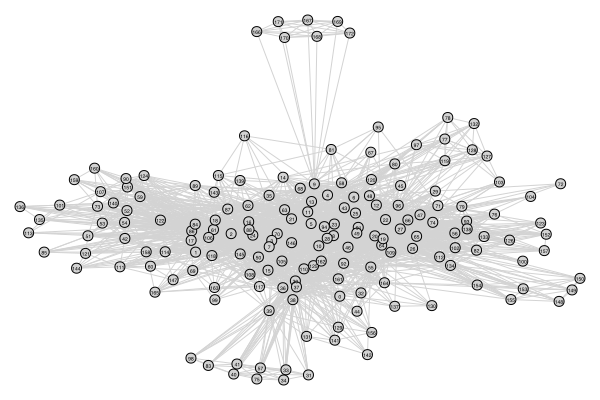

In [25]:
## visualize the 2-section graph
print('nodes:',G.vcount(),'edges:',G.ecount())
G.vs['size'] = 10
G.vs['color'] = 'lightgrey'
G.vs['label'] = [int(x) for x in G.vs['name']] ## use int(name) as label
G.vs['character'] = [GoT.nodes[n].name for n in G.vs['name']]
G.vs['label_size'] = 5
ly = G.layout_fruchterman_reingold()
ig.plot(G, layout = ly, bbox=(0,0,600,400), edge_color='lightgrey')


In [26]:
## we see a well-separated small clique; it is the Braavosi theater troup
print([GoT.nodes[str(x)].name for x in np.arange(166,173)])


['Izembaro', 'Lady Crane', 'Camello', 'Bobono', 'Bianca', 'Clarenzo', 'Margaery Tyrell Mummer']


In [27]:
## Compute modularity (qH) on several random partition with K parts for a range of K's
## This should be close to 0 and can be negative.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    h = []
    for K in np.arange(2,21):
        for rep in range(10):
            V = list(GoT.nodes)
            p = np.random.choice(K, size=len(V))
            RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
            ## drop empty sets if any
            RandPart = [x for x in RandPart if len(x)>0]
            ## compute qH
            h.append(hmod.modularity(GoT, RandPart, qH2))
print('range for qH:',min(h),'to',max(h))


range for qH: -0.06507421255679123 to 0.044756533958810706


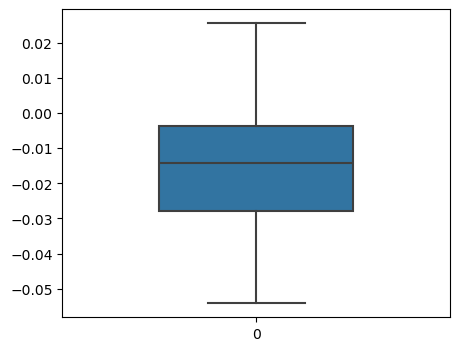

In [28]:
plt.figure(figsize=(5,4))
sns.boxplot(h, showfliers=False, width=.5);

In [29]:
## Cluster the 2-section graph (with Leiden) and compute qH
## We now see qH >> 0
random.seed(123)
G.vs['leiden'] = G.community_leiden(objective_function='modularity', weights='weight').membership
for v in G.vs:
    GoT.nodes[v['name']].leiden = v['leiden']
df['leiden_cluster'] = [GoT.nodes[v].leiden for v in GoT.nodes()]
ML = hmod.dict2part({v['name']:v['leiden'] for v in G.vs})
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    ## Compute qH
    print('qH (quadratic):',"{:.4f}".format(hmod.modularity(GoT, ML, qH2)))


qH (quadratic): 0.5445


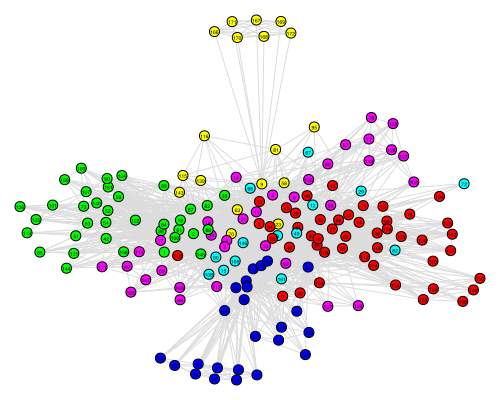

In [30]:
## plot 2-section w.r.t. the resulting clusters
cl = G.vs['leiden']

## pick greyscale or color plot:
#pal = ig.GradientPalette("white","black",max(cl)+2)
pal = ig.ClusterColoringPalette(max(cl)+2)

G.vs['color'] = [pal[x] for x in cl]
G.vs['label_size'] = 5
ig.plot(G, layout = ly, bbox=(0,0,500,400), edge_color='gainsboro')
#ig.plot(G, target='GoT_clusters.eps', layout = ly, bbox=(0,0,400,400))


In [31]:
## ex: high strength nodes in same cluster with Daenerys Targaryen
dt = df[df['name']=='Daenerys Targaryen']['leiden_cluster'].iloc[0]
df[df['leiden_cluster']==dt].sort_values(by='strength',ascending=False).head(9)

,name,degree,strength,s_betweenness,s_harmonic,pagerank,harmonic,betweenness,leiden_cluster
97,Daenerys Targaryen,220,30644,0.045043,0.008092,0.031988,0.101999,0.117762,2
103,Jorah Mormont,118,19344,0.030233,0.007661,0.020308,0.068226,0.005032,2
14,Missandei,92,13683,0.007734,0.007423,0.013900,0.069424,0.002482,2
30,Grey Worm,79,10416,0.008742,0.007480,0.010989,0.070070,0.015164,2
124,Barristan Selmy,35,6514,0.005789,0.006755,0.007237,0.026665,0.000000,2
104,Drogon,84,6396,0.026363,0.007548,0.007395,0.105640,0.092749,2
37,Daario Naharis,32,5370,0.000127,0.005542,0.005907,0.024265,0.000000,2
105,Rhaegal,49,3932,0.016791,0.007185,0.004902,0.065042,0.125322,2
100,Khal Drogo,14,3575,0.000007,0.005032,0.004687,0.006213,0.000000,2


In [32]:
## last step given 2-section Leiden
np.random.seed(321)
leiden = dict(zip(G.vs['name'],G.vs['leiden']))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ls = hmod.last_step(GoT, hmod.dict2part(leiden), qH2)
    print('qH (quadratic):',"{:.4f}".format(hmod.modularity(GoT, ls, qH2)))
    
ls_dict = hmod.part2dict(ls)
df['cluster_qH'] = [ls_dict[v] for v in GoT.nodes()]
G.vs['cluster_qH'] = [ls_dict[v['name']] for v in G.vs]

qH (quadratic): 0.5465


In [33]:
## which nodes were moved?
df[df.leiden_cluster != df.cluster_qH]

,name,degree,strength,s_betweenness,s_harmonic,pagerank,harmonic,betweenness,leiden_cluster,cluster_qH
6,Handmaid,7,235,0.000398,0.005678,0.001191,0.065957,0.070923,4,0
95,Ros,12,1849,0.000393,0.005916,0.002861,0.023842,0.000000,5,0
99,Dickon Tarly,9,1118,0.000047,0.005984,0.002158,0.024562,0.000000,0,1
143,Armeca,5,629,0.000013,0.005259,0.001552,0.010388,0.000000,5,0
145,Meryn Trant,30,2678,0.001623,0.006653,0.003699,0.040810,0.000204,0,3


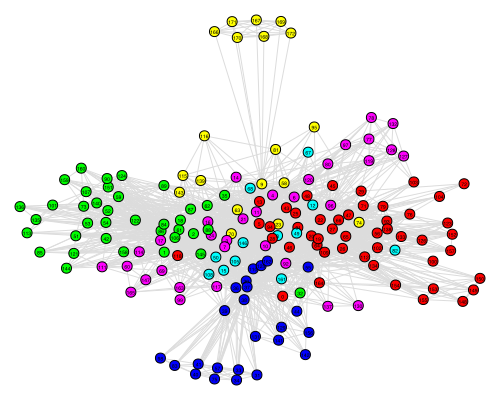

In [34]:
## plot 2-section w.r.t. the resulting clusters
cl = G.vs['cluster_qH']

## pick greyscale or color plot:
#pal = ig.GradientPalette("white","black",max(cl)+2)
pal = ig.ClusterColoringPalette(max(cl)+2)

G.vs['color'] = [pal[x] for x in cl]
G.vs['label_size'] = 5
ig.plot(G, layout = ly, bbox=(0,0,500,400), edge_color='gainsboro')
#ig.plot(G, target='GoT_clusters.eps', layout = ly, bbox=(0,0,400,400))


# h-ABCD Example

The small h-ABCD hypergraph we use next was generated as follows:

`julia --project abcdh.jl -n 100 -d 2.5,3,10 -c 1.5,30,40 -x .2 -q 0,.3,.4,.3 -w :strict -s 123 -o toy`

It has 100 nodes and 3 communities.
    

In [35]:
## read the edges and build the h-ABCD hypergraph H
fp = open(datadir+'ABCD/toy_he.txt', 'r')
Lines = fp.readlines()
Edges = []
for line in Lines:
    Edges.append(set([int(x) for x in line.strip().split(',')]))
H = hnx.Hypergraph(dict(enumerate(Edges)))
print('distribution of edge sizes:',Counter([len(x) for x in Edges]))


distribution of edge sizes: Counter({2: 70, 3: 59, 4: 31})


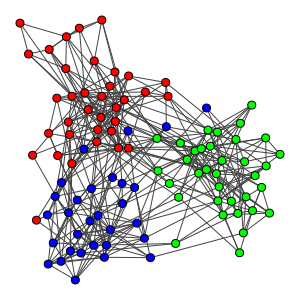

In [36]:
## read the ground-truth communities and assign node colors accordingly
H_comm = dict(zip(H.nodes,pd.read_csv(datadir+'ABCD/toy_assign.txt', header=None)[0].tolist()))
cls = ['red','green','blue']
node_colors = dict(zip(H.nodes, [cls[H_comm[i]-1] for i in H.nodes]))

## build the 2-section graph and plot (with ground-truth community colors)
g = hmod.two_section(H)
for v in g.vs:
    v['color'] = node_colors[v['name']]
    v['gt'] = H_comm[v['name']]
random.seed(42)
ly = g.layout_fruchterman_reingold()
ig.plot(g, vertex_size=8, bbox=(300,300), layout=ly)


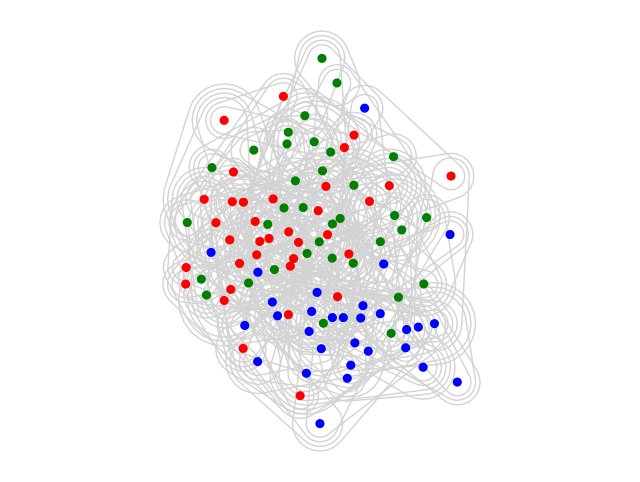

In [37]:
## draw as hypergraph ... already quite busy with 100 nodes!
kwargs = {'layout_kwargs': {'seed': 42}, 'with_node_counts': False}
plt.figure(figsize=(8,6))
hnx.draw(H, **kwargs, with_node_labels=False, with_edge_labels=False,
         nodes_kwargs={'facecolors': node_colors},
         edges_kwargs={'edgecolors': 'lightgrey'},
         layout = nx.fruchterman_reingold_layout)


### Edge composition

Recall we call a $d$-edge a **community** edge if $c>d/2$ where $c$ is the number of nodes that belong to the most represented community,

Below we show the number of edges with all values $d$ and $c$, community edges or not.

We see that given the ground-truth communities, most community edges are *pure* in the sense that $c=d$.


In [38]:
## edge composition - ground truth
L = []
for e in H.edges:
    L.append(tuple([x[1] for x in Counter([H_comm[i] for i in H.edges[e]]).most_common()]))
X = Counter(L).most_common()
L = []
for x in X:
    L.append([sum(x[0]), x[0][0], x[1], x[0][0]>sum(x[0])/2])
pd.DataFrame(np.array(L), columns=['d','c','frequency','community edge'])

,d,c,frequency,community edge
0,2,2,54,1
1,3,3,47,1
2,4,4,21,1
3,2,1,16,0
4,3,2,9,1
5,4,3,6,1
6,3,1,3,0
7,4,2,2,0
8,4,2,2,0


### with clustering

In real examples, we usually do not know the ground-truth communities, or at least not for every node.

We can try some clustering, form example graph clustering on the 2-section graph, or Kumar's algorithm on the hypergraph, to get a sense of edge composition.

The result is quite similar to the ground-truth.


In [39]:
## edge composition - clustering
random.seed(42)
H_kumar = hmod.kumar(H)
H_kumar_dict = hmod.part2dict(H_kumar)

L = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    for e in H.edges:
        L.append(tuple([x[1] for x in Counter([H_kumar_dict[i] for i in H.edges[e]]).most_common()]))
X = Counter(L).most_common()
L = []
for x in X:
    L.append([sum(x[0]), x[0][0], x[1], x[0][0]>sum(x[0])/2])
pd.DataFrame(np.array(L), columns=['d','c','frequency','community edge'])

/Users/francois/anaconda3/envs/complexnetworks/lib/python3.11/site-packages/hypernetx/classes/entity.py:1511: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self._properties.loc[item_key, prop_name] = prop_val


,d,c,frequency,community edge
0,2,2,57,1
1,3,3,47,1
2,4,4,19,1
3,2,1,13,0
4,3,2,10,1
5,4,3,7,1
6,4,2,3,0
7,4,2,2,0
8,3,1,2,0


### comparing clusterings

In the experiment below, we run each of the following algorithms 100 times and compare AMI with the ground-truth communities. 

* Leiden on 2-section (weighted) graph
* Kumar's algorithm
* Kumar's algorithm followed by 1 round trying to heuristically improve strict h-modularity

We observe that:

* Kumar's algorithm, which does take the hypergraph structure into account, improves on the results with 2-sectiopn clustering, and
* Modifications trying to heuristically improve stricy modularity (in view of edge composition we saw) slightly improves on the result with Kumar's algorithm.


In [40]:
L = []
for s in range(100):
    random.seed(s)
    np.random.seed(s)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    ami_g = AMI(g.vs['gt'], g.vs['leiden'])
    H_kumar = hmod.kumar(H)
    H_kumar_dict = hmod.part2dict(H_kumar)
    ami_k = AMI([H_comm[v] for v in H.nodes], [H_kumar_dict[v] for v in H.nodes]) 
    H_ls = hmod.part2dict(hmod.last_step(H, H_kumar, hmod.strict))
    ami_ls = AMI([H_comm[v] for v in H.nodes], [H_ls[v] for v in H.nodes])
    L.append([ami_g, ami_k, ami_ls])
D = pd.DataFrame(L, columns=['2-section', 'Kumar', 'h-modularity'])
print('median values:\n')
print(D.median())

median values:

2-section       0.704311
Kumar           0.741597
h-modularity    0.775600
dtype: float64


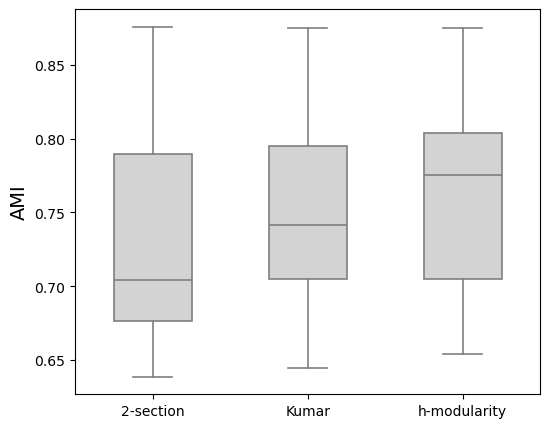

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    plt.figure(figsize=(6,5))
    sns.boxplot(D, width=.5, color='lightgray', linewidth=1.2)
    plt.ylabel('AMI', fontsize=14);

# Motifs example 

Using HNX draw function to get patterns from **Figure 7.1** in the book and count motifs reported in **Table 7.2**.

Given:
* E2: number of edges of size 2
* G(E2): graph built only with E2
* E3: edges of size 3

Compute:
* H1: number of subgraphs of 4-nodes in G(E2) with 5 edges + 6 times the number of 4-cliques in G(E2)
* H3: count pairs of edges in E3 with intersection of size 2
* H2: for each (i,j,k) in E3, count common neighbours in G(E2) for (i,j), (i,k) and (j,k) 

Random hypergraphs:
* probability for 2-edges: p2 = c/(n-1)
* probability for 3-edges to maintain expected 2-section graph degree:  p3 = (8-c)/((n-1)*(n-2)) 
* probability for 3-edges to maintain expected H-degree: p3 = (8-c)/((n-1)*(n/2-1))


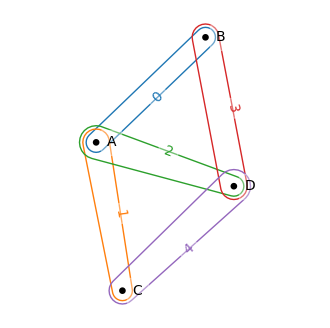

In [42]:
## H1 pattern
np.random.seed(123)
E = [{'A','B'},{'A','C'},{'A','D'},{'B','D'},{'C','D'}]
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(4,4))
hnx.draw(HG)

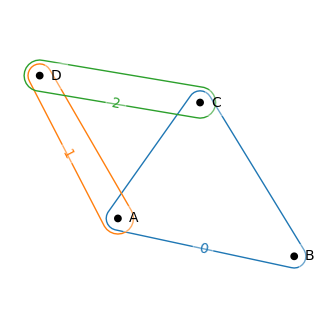

In [43]:
## H2 pattern
np.random.seed(123)
E = [{'A','B','C'},{'A','D'},{'C','D'}]
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(4,4))
hnx.draw(HG)

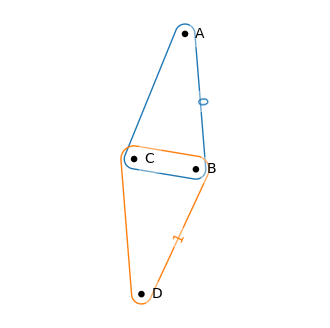

In [45]:
## H3 pattern
np.random.seed(123)
E = [{'A','B','C'},{'B','C','D'}]
HG = hnx.Hypergraph(dict(enumerate(E)))
plt.figure(figsize=(4,4))
hnx.draw(HG)
